In [ ]:
import os
from google.cloud import bigquery
import pandas as pd

In [ ]:
%load_ext google.cloud.bigquery 
#loads the bigquery module in our file

In [ ]:

PROJECT = "qwiklabs-gcp-04-af059b23c3fc"  # Replace with your PROJECT
BUCKET = PROJECT 
REGION = "us-central1"  

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

#saved them in the environment variables

In [ ]:
%%bigquery --project $PROJECT
#the variable $PROJECT can now be used 
#%%bigquery indicates ki writiung a SQL Command in this block


SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
#from the hosted dataset in bigquer of hacker news url title and score are traced
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

In [ ]:
%%bigquery --project $PROJECT
##IMP 1

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

In [ ]:
regex = '.*://(.[^/]+)/'
##IMP 2

sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query_todo = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query_todo)

In [ ]:
bq = bigquery.Client(project=PROJECT) #project from env variable 
title_dataset = bq.query(query_todo).to_dataframe()

In [ ]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [ ]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Shuffle the data before writing it to csv.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')
titles_df = pd.read_csv(FULL_DATASET_PATH, header=None, names=['title', 'source'])


In [ ]:
sample_title_dataset = title_dataset.sample(n=1000)
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [ ]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


Now WE WILL PRPARE THE LABELS ie one hot encode the outputs

In [ ]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}

In [ ]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    #this will return an array with values as 0 1 or 2
    one_hots = to_categorical(classes, num_classes=3)
    return one_hots

TRAINING THE DATASET

In [ ]:
N_TRAIN = int(len(titles_df) * 0.95)
titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])
X_train, Y_train = titles_train.values, encode_labels(sources_train) #WHY WE DID .VALUES WHEN IT WAS ALREADY A STRING ##DOUBT 1
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

## NNLM Model

In [ ]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"
nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True) #50 DIMENSIONAL ONE IS HOSTED SO WE USED OUTPUT AS 50 DIMENSIONS

In [ ]:
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

#### Now we will write a function which takes as input the instance of the KerasLayer and the name of the model and returns a KEras sequential model which includes 1. pre trained TF Hub 2. RELU Layers 3. Softmax 

In [ ]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module, # TODO 2
        Dense(16, activation='relu'), # we randomly chose 16 RELU layers 
        Dense(3, activation='softmax') #3 classes are there for our final encodining of the source of title 
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [ ]:
MODEL_DIR = "./text_models"
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33) ##DOUBT 2 ? meaning 

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train, #fit on training data
        epochs=50, #epochs are 50 
        batch_size=batch_size,
        validation_data=val_data, 
        callbacks=TensorBoard(model_dir),
    )
    return history

## Training NNLM and plotting loss , accuracy functions

In [ ]:
nnlm_model = build_model(nnlm_module, 'nnlm')
history=train_and_evaluate((X_train, Y_train), (X_valid, Y_valid), nnlm_model)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

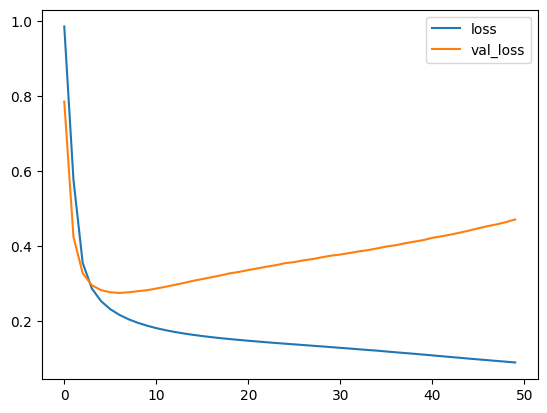

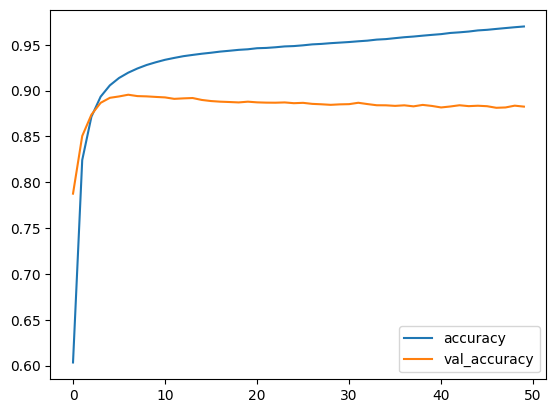

# THANKS FOR VIEWING
**PRATHAM GARG**